##Importing libraries

In [58]:
import datetime
from math import ceil
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [59]:
# !pip install xgboost

In [60]:
telemetry_df = pd.read_csv('azure/PdM_telemetry.csv') #Reading telemetry data (Volt,rpm,pressure,vibration)
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [61]:
telemetry_df['datetime'].min(), telemetry_df['datetime'].max()

('2015-01-01 06:00:00', '2016-01-01 06:00:00')

In [62]:
telemetry_df['machineID'].value_counts()

1      8761
64     8761
74     8761
73     8761
72     8761
       ... 
31     8761
30     8761
29     8761
28     8761
100    8761
Name: machineID, Length: 100, dtype: int64

In [63]:
telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].describe()

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


In [64]:
telemetry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [65]:
failures = pd.read_csv('azure/PdM_failures.csv')
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


In [66]:
failures = failures.sort_values(by='datetime')
failures.reset_index(inplace=True, drop=True)
failures.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,56,comp3
1,2015-01-02 03:00:00,99,comp3
2,2015-01-02 03:00:00,83,comp4
3,2015-01-02 03:00:00,59,comp1
4,2015-01-02 03:00:00,16,comp1


In [67]:
failures['failure'].value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

In [68]:
telemetry_with_failure_df = telemetry_df.merge(failures, on=['datetime', 'machineID'], how='left')
telemetry_with_failure_df.fillna('No Failure', inplace=True)

In [69]:
telemetry_with_failure_df['failure'].value_counts()

No Failure    875381
comp2            259
comp1            192
comp4            179
comp3            131
Name: failure, dtype: int64

In [70]:
machine_info = pd.read_csv('azure/PdM_machines.csv')
machine_info.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [71]:
telemetry_with_failure_df = machine_info.merge(right=telemetry_with_failure_df, on=['machineID'], how='left')
telemetry_with_failure_df.head(-10)

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure
...,...,...,...,...,...,...,...,...,...
876127,100,model4,5,2015-12-31 16:00:00,164.729171,448.894575,99.763131,43.916301,No Failure
876128,100,model4,5,2015-12-31 17:00:00,191.020128,537.789373,105.847232,45.791265,No Failure
876129,100,model4,5,2015-12-31 18:00:00,196.932834,360.053876,102.923230,30.398181,No Failure
876130,100,model4,5,2015-12-31 19:00:00,138.506098,497.861210,112.525039,34.867196,No Failure


In [72]:
telemetry_with_failure_df['model'].value_counts()

model3    306644
model4    280363
model2    148945
model1    140190
Name: model, dtype: int64

In [73]:
def strToDatetime(date_array, format):
    new_datetime = list()
    for date in date_array:
        new_datetime.append(datetime.datetime.strptime(date, format))
    return new_datetime

In [74]:
datetime_column = strToDatetime(telemetry_with_failure_df['datetime'], '%Y-%m-%d %H:%M:%S')

In [75]:
telemetry_with_failure_df['datetime'] = datetime_column

In [76]:
telemetry_with_failure_df['datetime'].min(), telemetry_with_failure_df['datetime'].max()

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

In [77]:
machine_ids = np.arange(1, 101)
len(machine_ids)

100

In [78]:
def hours_estimation(machine_id):
    df = telemetry_with_failure_df[telemetry_with_failure_df['machineID'] == machine_id]
    df.reset_index(drop=True, inplace=True)
    rul = []
    cont = len(df['failure']) - 1
    diff = 0
    while cont >= df.index.min():
        if df['failure'][cont] == 'No Failure':
            diff = diff + 1
            rul.append(diff)
        else:
            rul.append(0)
            diff = 0
        diff = rul[-1]
        cont = cont - 1
    df['hours_to_fail'] = list(reversed(rul))
    return df

In [79]:
dfs = []
for machine_id in machine_ids:
    df = hours_estimation(machine_id)
    dfs.append(df)

In [80]:
telemetry = pd.DataFrame()
for df in dfs:
    telemetry = pd.concat([telemetry, df], axis=0)

In [81]:
print(telemetry.shape[0], telemetry_with_failure_df.shape[0])

876142 876142


In [82]:
telemetry['seconds_to_fail'] = telemetry['hours_to_fail'] * 3600
telemetry.drop('hours_to_fail', axis=1, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200


In [83]:
# sns.heatmap(telemetry.corr(), annot=True).figure.set_size_inches(12, 9)

In [84]:
telemetry.columns

Index(['machineID', 'model', 'age', 'datetime', 'volt', 'rotate', 'pressure',
       'vibration', 'failure', 'seconds_to_fail'],
      dtype='object')

In [85]:
datetimes = telemetry['datetime']
timestamps = list()
for datetime_ in datetimes:
    timestamps.append(datetime.datetime.timestamp(datetime_))    
datetimes.shape[0], len(timestamps)

(876142, 876142)

In [86]:
telemetry['timestamp'] = timestamps
#telemetry.drop('datetime', axis=1, inplace=True)
#telemetry = telemetry[['timestamp', 'machineID', 'model', 'age', 'volt', 'rotate', 'pressure', 'vibration', 'failure', 'seconds_to_fail']]
telemetry

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600,1.420072e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000,1.420076e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400,1.420079e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800,1.420083e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200,1.420087e+09
...,...,...,...,...,...,...,...,...,...,...,...
8756,100,model4,5,2016-01-01 02:00:00,179.438162,395.222827,102.290715,50.771941,No Failure,18000,1.451594e+09
8757,100,model4,5,2016-01-01 03:00:00,189.617555,446.207972,98.180607,35.123072,No Failure,14400,1.451597e+09
8758,100,model4,5,2016-01-01 04:00:00,192.483414,447.816524,94.132837,48.314561,No Failure,10800,1.451601e+09
8759,100,model4,5,2016-01-01 05:00:00,165.475310,413.771670,104.081073,44.835259,No Failure,7200,1.451605e+09


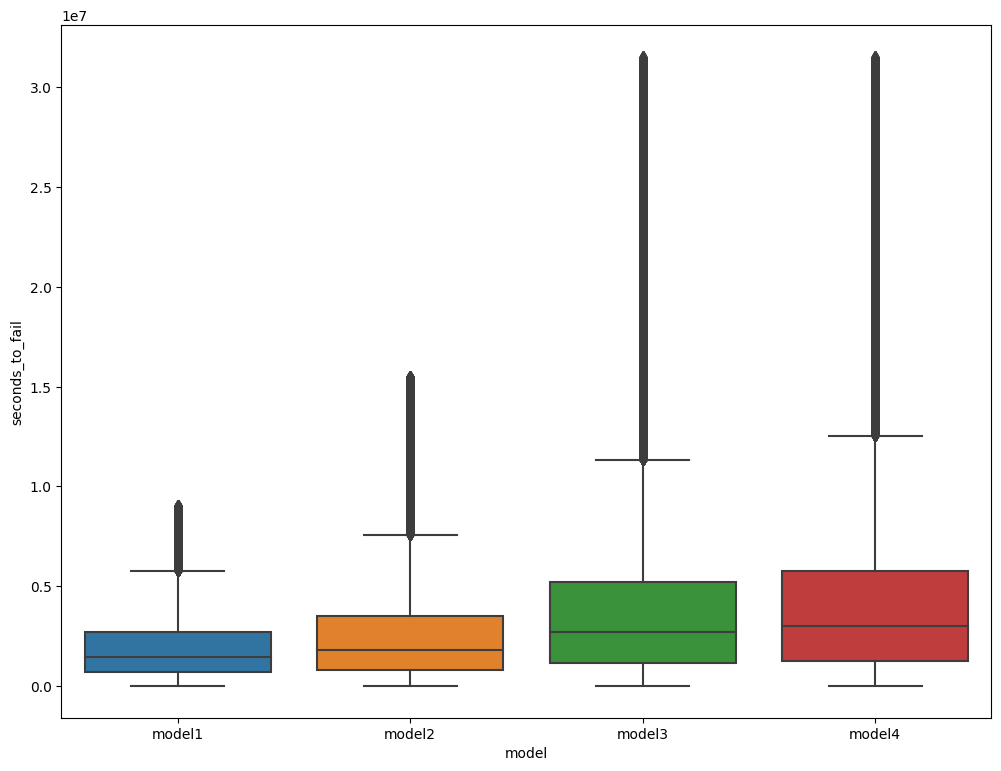

In [87]:
sns.boxplot(x=telemetry['model'], y=telemetry['seconds_to_fail'], order=['model1', 'model2', 'model3', 'model4']).figure.set_size_inches(12, 9)

In [88]:
telemetry['model'].value_counts()

model3    306644
model4    280363
model2    148945
model1    140190
Name: model, dtype: int64

##Make change for model here 

In [89]:
model3_data = telemetry[telemetry['model'] == 'model3'].reset_index(drop=True)
model3_data

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,345600,1.420072e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,342000,1.420076e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,338400,1.420079e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,334800,1.420083e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,331200,1.420087e+09
...,...,...,...,...,...,...,...,...,...,...,...
306639,93,model3,18,2016-01-01 02:00:00,202.858467,412.870855,85.569847,47.701614,No Failure,18000,1.451594e+09
306640,93,model3,18,2016-01-01 03:00:00,171.364527,459.880473,94.316793,47.592136,No Failure,14400,1.451597e+09
306641,93,model3,18,2016-01-01 04:00:00,182.867119,491.584480,90.332643,58.592710,No Failure,10800,1.451601e+09
306642,93,model3,18,2016-01-01 05:00:00,166.943545,352.047138,82.068954,46.256361,No Failure,7200,1.451605e+09


In [90]:
def create_time_step(data, machine_id):
    machine_id_data = data[data['machineID'] == machine_id]
    time_step = np.arange(1, machine_id_data.shape[0]+1)
    machine_id_data['time_step'] = time_step
    return machine_id_data

In [91]:
machineIDs = model3_data['machineID'].unique()
dataframes_with_time_step = []
for machine_id in machineIDs:
    dataframes_with_time_step.append(create_time_step(model3_data, machine_id))
len(dataframes_with_time_step)

35

In [92]:
model3_data = pd.DataFrame()
for df in dataframes_with_time_step:
    model3_data = pd.concat([model3_data, df])

In [93]:
#model3_data = model3_data[['age', 'volt', 'rotate', 'pressure', 'vibration', 'seconds_to_fail']]
model3_data.drop(['model', 'failure', 'datetime', 'timestamp', 'machineID'], axis=1, inplace=True)
model3_data

,age,volt,rotate,pressure,vibration,seconds_to_fail,time_step
0,18,176.217853,418.504078,113.077935,45.087686,345600,1
1,18,162.879223,402.747490,95.460525,43.413973,342000,2
2,18,170.989902,527.349825,75.237905,34.178847,338400,3
3,18,162.462833,346.149335,109.248561,41.122144,334800,4
4,18,157.610021,435.376873,111.886648,25.990511,331200,5
...,...,...,...,...,...,...,...
306639,18,202.858467,412.870855,85.569847,47.701614,18000,8757
306640,18,171.364527,459.880473,94.316793,47.592136,14400,8758
306641,18,182.867119,491.584480,90.332643,58.592710,10800,8759
306642,18,166.943545,352.047138,82.068954,46.256361,7200,8760


In [94]:
scaler = MinMaxScaler()

normalized_telemetry = pd.DataFrame(data=scaler.fit_transform(model3_data), columns=model3_data.columns)
normalized_telemetry.head()

,age,volt,rotate,pressure,vibration,seconds_to_fail,time_step
0,0.894737,0.510638,0.469652,0.472451,0.476569,0.010958,0.000000
1,0.894737,0.421045,0.439431,0.337821,0.448935,0.010844,0.000114
2,0.894737,0.475523,0.678413,0.183282,0.296461,0.010729,0.000228
3,0.894737,0.418248,0.330878,0.443188,0.411097,0.010615,0.000342
4,0.894737,0.385652,0.502013,0.463348,0.161269,0.010501,0.000457


In [95]:
#Split in 80-20% without random
train_size = ceil(normalized_telemetry.shape[0] * 0.8)
test_size = ceil(normalized_telemetry.shape[0] * 0.2)
print(f'Train size: {train_size}')
print(f'Test size: {test_size}')

Train size: 245316
Test size: 61329


In [96]:
# scaler = MinMaxScaler()

# normalized_telemetry = pd.DataFrame(data=scaler.fit_transform(model3_data), columns=model3_data.columns)
# normalized_telemetry.head()

In [97]:
#Resetting index for split
train_set = normalized_telemetry[:train_size]

test_set = normalized_telemetry[train_size:].reset_index(drop=True)

train_set.shape, test_set.shape

((245316, 7), (61328, 7))

In [98]:
# train_size = ceil(normalized_telemetry.shape[0] * 0.7)
# test_and_val_size = ceil((normalized_telemetry.shape[0] * 0.3) / 2)
# print(f'Train size: {train_size}')
# print(f'Test and validation size: {test_and_val_size}')

In [100]:
X_train = train_set.drop('seconds_to_fail', axis=1)
X_train = np.array(X_train)
y_train = train_set['seconds_to_fail']
y_train = np.array(y_train)

X_test = test_set.drop('seconds_to_fail', axis=1)
X_test = np.array(X_test)
y_test = test_set['seconds_to_fail']
y_test = np.array(y_test)

# X_valid = val_set.drop('seconds_to_fail', axis=1)
# X_valid = np.array(X_valid)
# y_valid = val_set['seconds_to_fail']
# y_valid = np.array(y_valid)

In [101]:
def print_plot(y_test, predict):
  error = mean_absolute_error(y_test, predict)
  print(f'MAE:{error}')
  mse = mean_squared_error(y_test, predict)
  print(f'MSE:{mse}')
  X = np.arange(y_test.shape[0])
#   plt.plot(y_test, color='red')
  plt.scatter(X,y_test, color='red',s=1)
#   plt.plot(predict, color='blue')
  plt.scatter(X,predict, color='blue',s=1)
  plt.ylim([0, 0.7])
  plt.show()

In [102]:
## Creating models and prediction 

In [103]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
# linear_model.coef_, linear_model.intercept_

LinearRegression()

In [104]:
predict = linear_model.predict(X_test)
print(predict.shape)

(61328,)


MAE:0.10243222524701144
MSE:0.01792751636181576


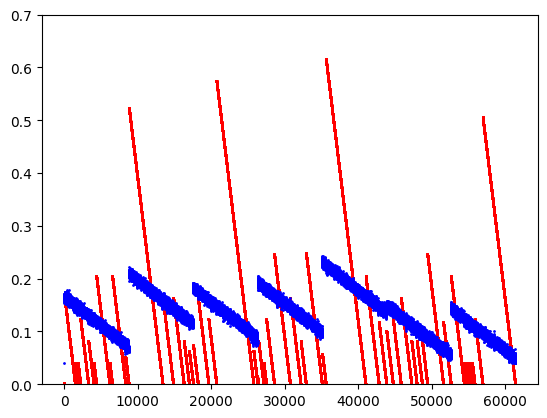

In [105]:
print_plot(y_test,predict)

In [106]:
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth':[2,4,6]}

In [107]:
regressor = DecisionTreeRegressor(random_state=0)
clf = GridSearchCV(regressor, parameters, cv=5, verbose=4)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .......................max_depth=2;, score=0.103 total time=   0.2s
[CV 2/5] END ......................max_depth=2;, score=-0.142 total time=   0.2s
[CV 3/5] END .......................max_depth=2;, score=0.170 total time=   0.2s
[CV 4/5] END ......................max_depth=2;, score=-0.174 total time=   0.2s
[CV 5/5] END ......................max_depth=2;, score=-0.391 total time=   0.2s
[CV 1/5] END ......................max_depth=4;, score=-0.073 total time=   0.3s
[CV 2/5] END ......................max_depth=4;, score=-0.232 total time=   0.3s
[CV 3/5] END .......................max_depth=4;, score=0.073 total time=   0.3s
[CV 4/5] END ......................max_depth=4;, score=-1.170 total time=   0.3s
[CV 5/5] END ......................max_depth=4;, score=-0.059 total time=   0.3s
[CV 1/5] END ......................max_depth=6;, score=-0.173 total time=   0.5s
[CV 2/5] END ......................max_depth=6;, 

MAE:0.09926797829055775
MSE:0.017012905018219476


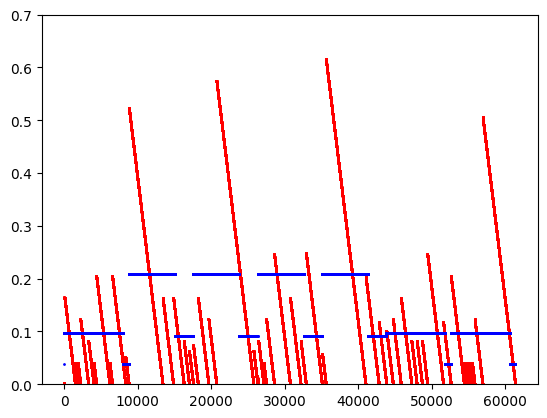

In [108]:
regressor = DecisionTreeRegressor(max_depth= 2,random_state=0)
regressor.fit(X_train, y_train)
predict = regressor.predict(X_test)
print_plot(y_test,predict)

In [109]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(random_state=42)
parameters = {'n_estimators':[50,100,200],'max_depth':[2,4,6]}
clf = GridSearchCV(regr, parameters, cv=5, verbose=4)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ......max_depth=2, n_estimators=50;, score=0.104 total time=   5.4s
[CV 2/5] END .....max_depth=2, n_estimators=50;, score=-0.153 total time=   5.4s
[CV 3/5] END ......max_depth=2, n_estimators=50;, score=0.171 total time=   5.4s
[CV 4/5] END .....max_depth=2, n_estimators=50;, score=-0.173 total time=   5.4s
[CV 5/5] END .....max_depth=2, n_estimators=50;, score=-0.391 total time=   5.4s
[CV 1/5] END .....max_depth=2, n_estimators=100;, score=0.104 total time=  10.7s
[CV 2/5] END ....max_depth=2, n_estimators=100;, score=-0.150 total time=  10.8s
[CV 3/5] END .....max_depth=2, n_estimators=100;, score=0.171 total time=  10.7s
[CV 4/5] END ....max_depth=2, n_estimators=100;, score=-0.173 total time=  10.9s
[CV 5/5] END ....max_depth=2, n_estimators=100;, score=-0.390 total time=  10.7s
[CV 1/5] END .....max_depth=2, n_estimators=200;, score=0.104 total time=  21.4s
[CV 2/5] END ....max_depth=2, n_estimators=200;, 

MAE:0.09914490951978543
MSE:0.016992980120973108


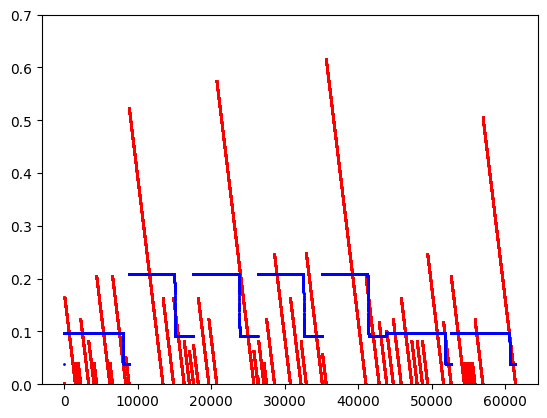

In [110]:
regressor = RandomForestRegressor(n_estimators= 200, max_depth= 2,random_state=42)
regressor.fit(X_train, y_train)
predict = regressor.predict(X_test)
print_plot(y_test,predict)

In [ ]:
regr = XGBRegressor()
parameters = {'n_estimators':[50,100,200,400],'max_depth':[2,4,6],'eta':[0.1, 0.01,0.001],'subsample':[0.7,0.8,0.9], 'colsample_bytree':[0.7,0.8,0.9]}
clf = GridSearchCV(regr, parameters, cv=5, verbose=4)
clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.7;, score=0.162 total time=   0.7s
[CV 2/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.7;, score=-0.233 total time=   0.7s
[CV 3/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.7;, score=0.100 total time=   0.6s
[CV 4/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.7;, score=-0.675 total time=   0.6s
[CV 5/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.7;, score=-0.110 total time=   0.6s
[CV 1/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.8;, score=0.165 total time=   0.6s
[CV 2/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0.8;, score=-0.222 total time=   0.6s
[CV 3/5] END colsample_bytree=0.7, eta=0.1, max_depth=2, n_estimators=50, subsample=0

[CV 3/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.042 total time=   1.2s
[CV 4/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=-1.111 total time=   1.2s
[CV 5/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=-0.577 total time=   1.2s
[CV 1/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.178 total time=   1.3s
[CV 2/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=-0.421 total time=   1.2s
[CV 3/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=0.042 total time=   1.2s
[CV 4/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=-1.104 total time=   1.2s
[CV 5/5] END colsample_bytree=0.7, eta=0.1, max_depth=4, n_estimators=50, subsample=0.9;, score=-0.583 total time=   1.2s
[CV 1/5] END colsample_bytr

[CV 5/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=-0.855 total time=   1.9s
[CV 1/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.7;, score=0.165 total time=   3.9s
[CV 2/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.7;, score=-0.685 total time=   3.9s
[CV 3/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.7;, score=-0.036 total time=   3.8s
[CV 4/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.7;, score=-1.263 total time=   3.8s
[CV 5/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.7;, score=-1.165 total time=   3.9s
[CV 1/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=0.165 total time=   3.9s
[CV 2/5] END colsample_bytree=0.7, eta=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=-0.698 total time=   3.9s
[CV 3/5] END colsam

[CV 2/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=-1.560 total time=   1.5s
[CV 3/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=-0.311 total time=   1.5s
[CV 4/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=-3.642 total time=   1.5s
[CV 5/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=-3.495 total time=   1.5s
[CV 1/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=-0.165 total time=   1.5s
[CV 2/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=-1.561 total time=   1.5s
[CV 3/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=-0.310 total time=   1.5s
[CV 4/5] END colsample_bytree=0.7, eta=0.01, max_depth=2, n_estimators=100, subsample=0.9;, score=-3.643 total time=   1.5s
[CV 5/5]

[CV 4/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=100, subsample=0.9;, score=-4.193 total time=   2.6s
[CV 5/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=100, subsample=0.9;, score=-3.407 total time=   2.6s
[CV 1/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=200, subsample=0.7;, score=0.125 total time=   5.2s
[CV 2/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=200, subsample=0.7;, score=-0.334 total time=   5.2s
[CV 3/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=200, subsample=0.7;, score=0.111 total time=   5.2s
[CV 4/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=200, subsample=0.7;, score=-1.406 total time=   5.2s
[CV 5/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=200, subsample=0.7;, score=-0.784 total time=   5.2s
[CV 1/5] END colsample_bytree=0.7, eta=0.01, max_depth=4, n_estimators=200, subsample=0.8;, score=0.125 total time=   5.2s
[CV 2/5] EN

[CV 1/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=0.138 total time=   7.9s
[CV 2/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=-0.386 total time=   8.3s
[CV 3/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=0.095 total time=   8.0s
[CV 4/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=-1.478 total time=   7.9s
[CV 5/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=-0.810 total time=   7.9s
[CV 1/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.9;, score=0.138 total time=   7.9s
[CV 2/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.9;, score=-0.387 total time=   7.9s
[CV 3/5] END colsample_bytree=0.7, eta=0.01, max_depth=6, n_estimators=200, subsample=0.9;, score=0.095 total time=   7.9s
[CV 4/5] END

[CV 2/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=200, subsample=0.9;, score=-7.695 total time=   3.1s
[CV 3/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=200, subsample=0.9;, score=-2.749 total time=   3.1s
[CV 4/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=200, subsample=0.9;, score=-15.581 total time=   3.1s
[CV 5/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=200, subsample=0.9;, score=-14.499 total time=   3.1s
[CV 1/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=400, subsample=0.7;, score=-0.986 total time=   6.5s
[CV 2/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=400, subsample=0.7;, score=-5.151 total time=   6.7s
[CV 3/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=400, subsample=0.7;, score=-1.719 total time=   6.6s
[CV 4/5] END colsample_bytree=0.7, eta=0.001, max_depth=2, n_estimators=400, subsample=0.7;, score=-10.750 total time=   6.

[CV 3/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.7;, score=-1.678 total time=  11.1s
[CV 4/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.7;, score=-11.108 total time=  11.0s
[CV 5/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.7;, score=-9.983 total time=  11.3s
[CV 1/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.8;, score=-0.981 total time=  11.6s
[CV 2/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.8;, score=-5.064 total time=  11.4s
[CV 3/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.8;, score=-1.678 total time=  11.5s
[CV 4/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.8;, score=-11.109 total time=  11.3s
[CV 5/5] END colsample_bytree=0.7, eta=0.001, max_depth=4, n_estimators=400, subsample=0.8;, score=-9.983 total time=  11.2

[CV 4/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.8;, score=-11.153 total time=  15.8s
[CV 5/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.8;, score=-9.994 total time=  15.5s
[CV 1/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.9;, score=-0.983 total time=  15.5s
[CV 2/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.9;, score=-5.057 total time=  15.7s
[CV 3/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.9;, score=-1.675 total time=  15.5s
[CV 4/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.9;, score=-11.152 total time=  15.5s
[CV 5/5] END colsample_bytree=0.7, eta=0.001, max_depth=6, n_estimators=400, subsample=0.9;, score=-9.988 total time=  15.6s
[CV 1/5] END colsample_bytree=0.8, eta=0.1, max_depth=2, n_estimators=50, subsample=0.7;, score=0.162 total time=   0.8s
[C

[CV 1/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.178 total time=   1.4s
[CV 2/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=-0.404 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=0.037 total time=   1.3s
[CV 4/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=-1.147 total time=   1.4s
[CV 5/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.7;, score=-0.610 total time=   1.4s
[CV 1/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.176 total time=   1.4s
[CV 2/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=-0.411 total time=   1.4s
[CV 3/5] END colsample_bytree=0.8, eta=0.1, max_depth=4, n_estimators=50, subsample=0.8;, score=0.042 total time=   1.4s
[CV 4/5] END colsample_bytre

[CV 3/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=-0.008 total time=   2.0s
[CV 4/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=-1.142 total time=   2.0s
[CV 5/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.8;, score=-0.840 total time=   2.0s
[CV 1/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=0.172 total time=   2.0s
[CV 2/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=-0.579 total time=   2.1s
[CV 3/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=-0.007 total time=   2.1s
[CV 4/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=-1.134 total time=   2.0s
[CV 5/5] END colsample_bytree=0.8, eta=0.1, max_depth=6, n_estimators=50, subsample=0.9;, score=-0.855 total time=   2.1s
[CV 1/5] END colsample_by

[CV 5/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=50, subsample=0.9;, score=-8.376 total time=   0.8s
[CV 1/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.7;, score=-0.165 total time=   1.7s
[CV 2/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.7;, score=-1.562 total time=   1.7s
[CV 3/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.7;, score=-0.310 total time=   1.7s
[CV 4/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.7;, score=-3.641 total time=   1.7s
[CV 5/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.7;, score=-3.495 total time=   1.7s
[CV 1/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=-0.165 total time=   1.6s
[CV 2/5] END colsample_bytree=0.8, eta=0.01, max_depth=2, n_estimators=100, subsample=0.8;, score=-1.560 total time=   1.6s
[CV 3/5] 

[CV 2/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=-1.502 total time=   2.7s
[CV 3/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=-0.279 total time=   2.7s
[CV 4/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=-4.193 total time=   2.7s
[CV 5/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.8;, score=-3.406 total time=   2.7s
[CV 1/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.9;, score=-0.155 total time=   2.7s
[CV 2/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.9;, score=-1.501 total time=   2.8s
[CV 3/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.9;, score=-0.278 total time=   2.7s
[CV 4/5] END colsample_bytree=0.8, eta=0.01, max_depth=4, n_estimators=100, subsample=0.9;, score=-4.193 total time=   3.1s
[CV 5/5]

[CV 4/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=100, subsample=0.9;, score=-4.258 total time=   4.0s
[CV 5/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=100, subsample=0.9;, score=-3.451 total time=   4.0s
[CV 1/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=200, subsample=0.7;, score=0.139 total time=   7.9s
[CV 2/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=200, subsample=0.7;, score=-0.391 total time=   8.1s
[CV 3/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=200, subsample=0.7;, score=0.094 total time=   8.1s
[CV 4/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=200, subsample=0.7;, score=-1.476 total time=   8.0s
[CV 5/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=200, subsample=0.7;, score=-0.816 total time=   8.4s
[CV 1/5] END colsample_bytree=0.8, eta=0.01, max_depth=6, n_estimators=200, subsample=0.8;, score=0.138 total time=  10.5s
[CV 2/5] EN

MAE:0.11116962156859006
MSE:0.021075903045515775


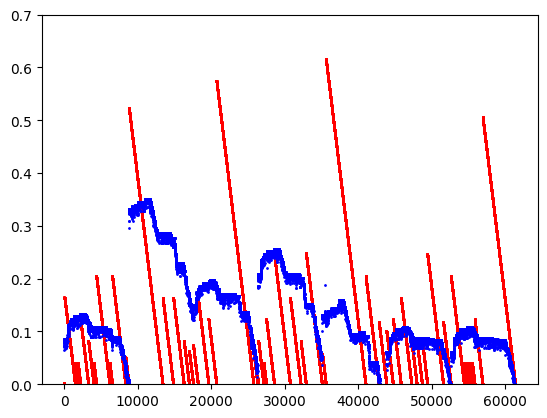

In [112]:
regr = XGBRegressor(n_estimators=100,max_depth=2,eta=0.1,subsample=0.7, colsample_bytree=0.7)
regr.fit(X_train, y_train)
predict = regr.predict(X_test)
print_plot(y_test,predict)

MAE:0.098498796274262
MSE:0.01674065622000485


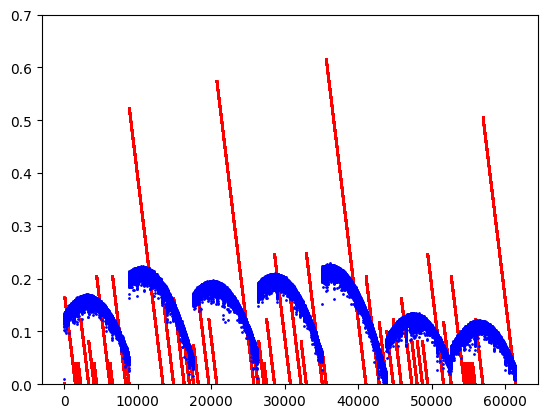

MAE:0.10290622178199671
MSE:0.018717395422053706


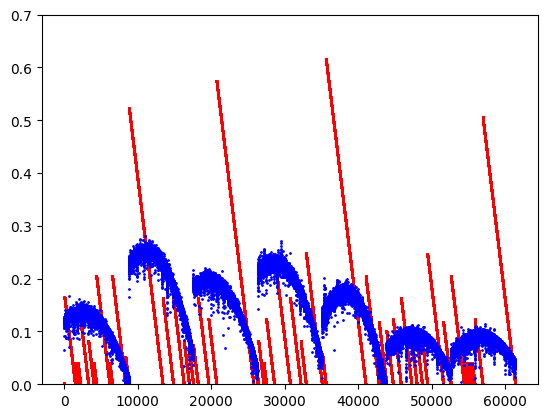

MAE:0.10044582915726975
MSE:0.019175148078966787


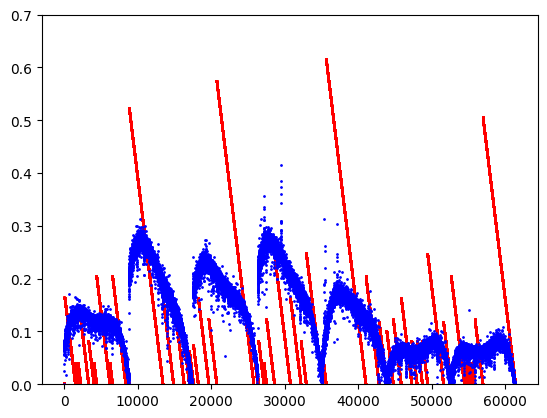

In [113]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
# define the pipeline and train model
for i in range(2,5,1):
    model = Pipeline([('poly', PolynomialFeatures(degree=i)),('linear', LinearRegression())])
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print_plot(y_test, predict)

In [ ]:
#Skip this model 
from sklearn.linear_model import RANSACRegressor

# Set RANSAC hyperparameters
ransac = RANSACRegressor(LinearRegression(),
		max_trials=4, 		# Number of Iterations
		min_samples=2, 		# Minimum size of the sample
		loss='squared_error', 	# Metrics for loss
		residual_threshold=10 	# Threshold
		)

# Train model
ransac.fit(X_train, y_train)
predict = ransac.predict(X_test)
print_plot(y_test,predict)

###Below cell takes long time to run. Skip running this again and again!!

0.13509878199866351
MAE:0.10243318045356896
MSE:0.01792810142397608


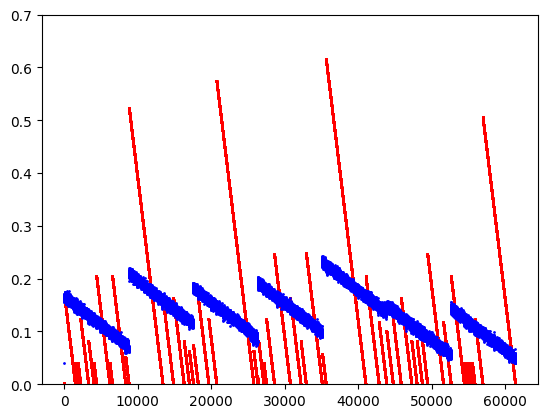

0.13502024798177495
MAE:0.10244223582755371
MSE:0.017936228424073587


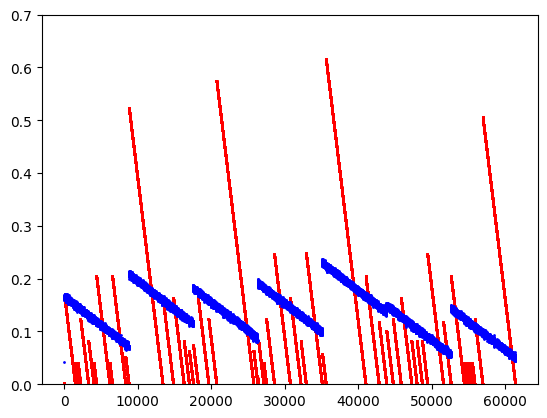

0.13428996859141
MAE:0.10237112214115472
MSE:0.018012797612963247


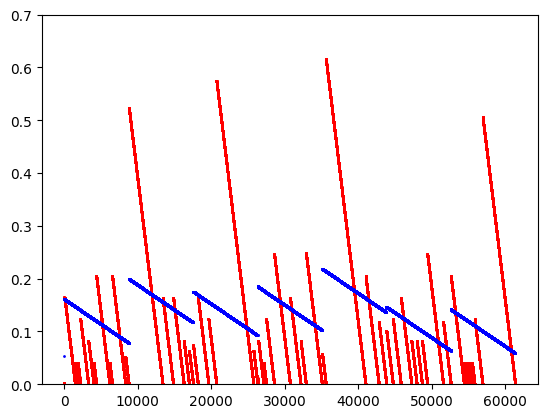

0.12808551178096186
MAE:0.10473851286162118
MSE:0.019936266373857862


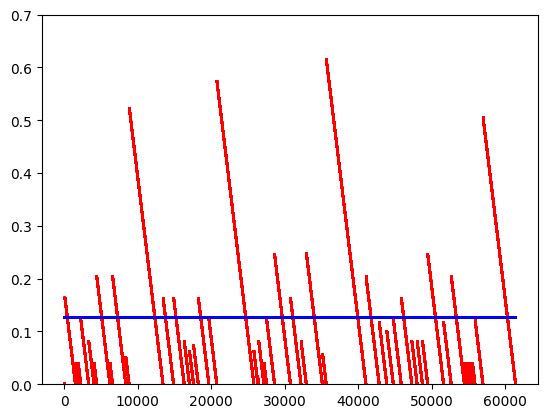

0.12808551178096186
MAE:0.10473851286162118
MSE:0.019936266373857862


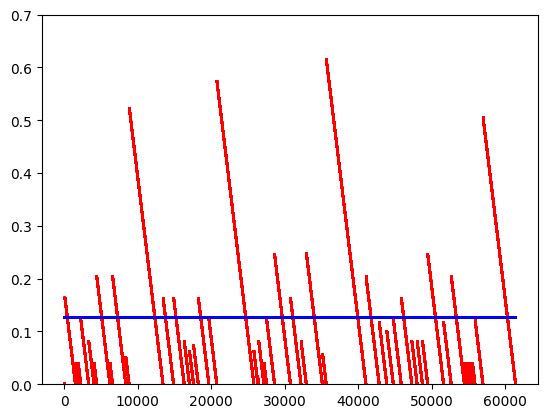

0.12808551178096186
MAE:0.10473851286162118
MSE:0.019936266373857862


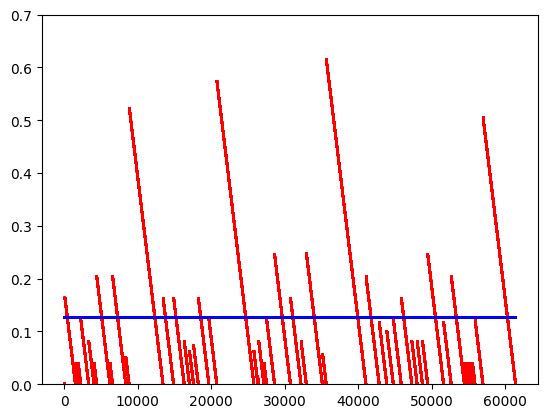

0.12808551178096186
MAE:0.10473851286162118
MSE:0.019936266373857862


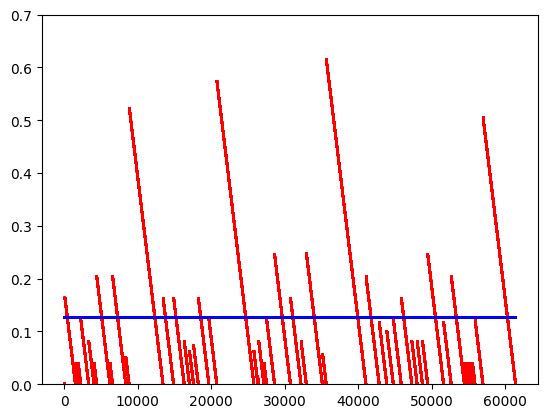

0.12808551178096186
MAE:0.10473851286162118
MSE:0.019936266373857862


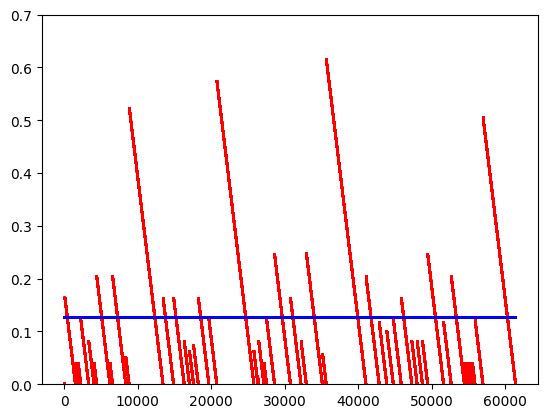

In [114]:
from sklearn.linear_model import Lasso
for i in range(-5,3,1):
    temp = 10**(i)
    model = Lasso(alpha=temp)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(np.average(predict))
    print_plot(y_test,predict)

MAE:0.10243222453424439
MSE:0.017927516519104066


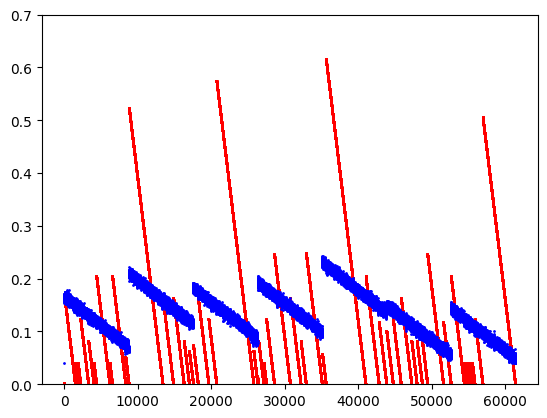

MAE:0.1024322181193136
MSE:0.017927517934769696


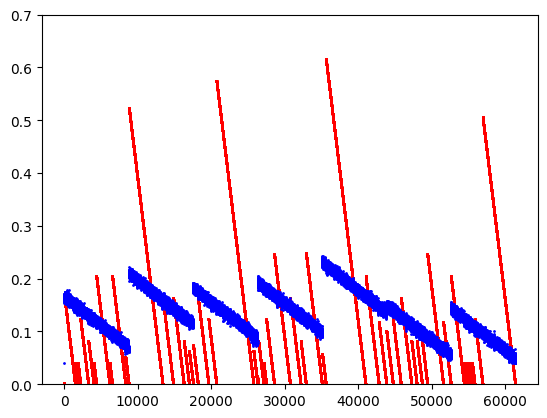

MAE:0.1024321539679545
MSE:0.01792753209825829


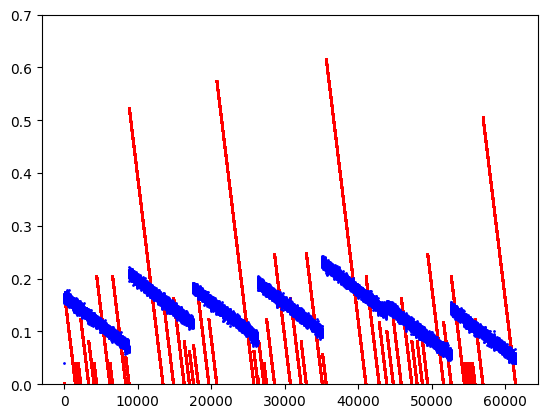

MAE:0.10243151245005215
MSE:0.01792767441238903


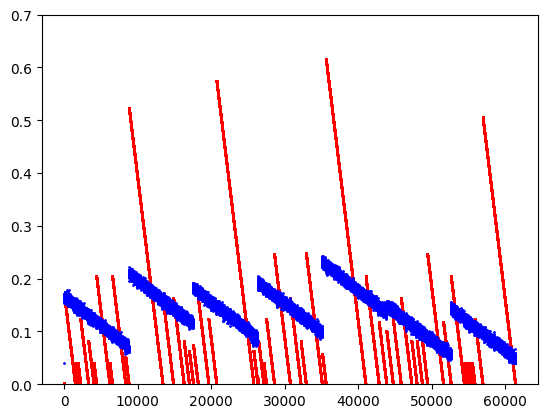

MAE:0.10242520991172796
MSE:0.01792916173979946


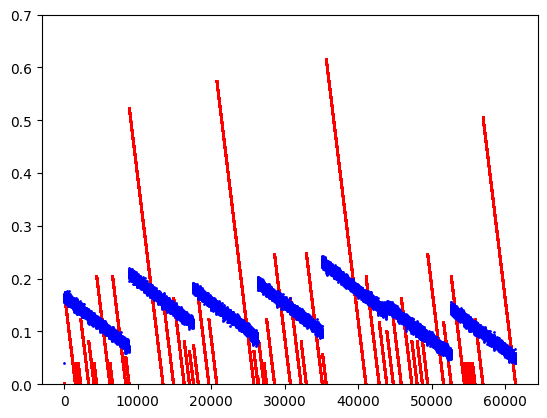

In [115]:
from sklearn.linear_model import Ridge
for i in range(-5,3,1):
    temp = 10**(i)
    model = Ridge(alpha=temp)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print_plot(y_test,predict)

MAE:0.11274370819667709
MSE:0.028234095920320834


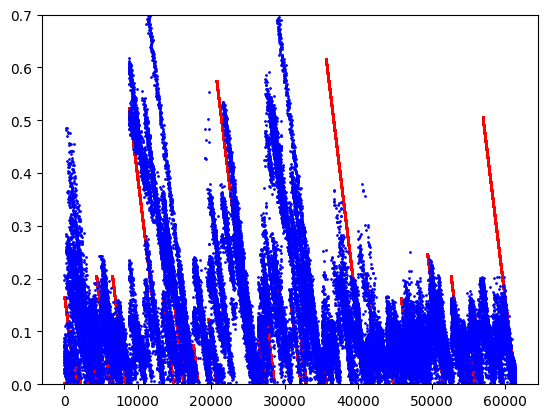

MAE:0.10552267770012687
MSE:0.024093695213517854


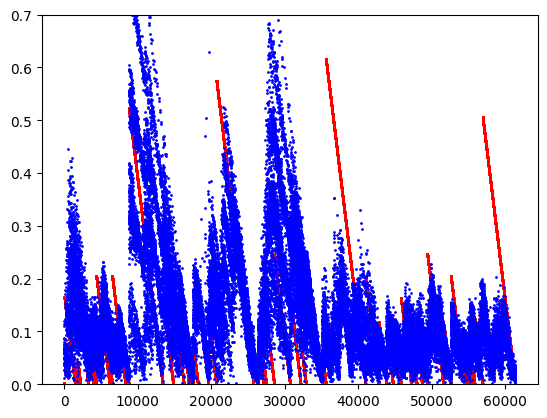

MAE:0.10080042297763017
MSE:0.021693392015990097


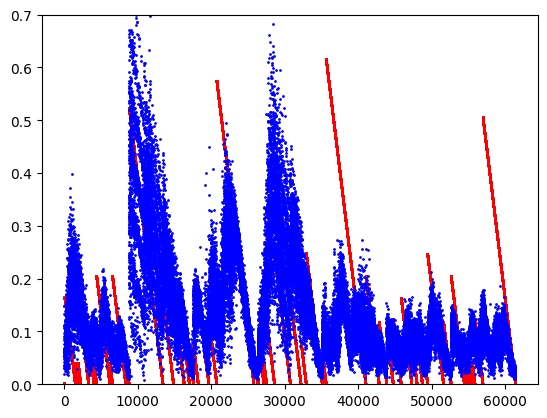

MAE:0.09791378492207016
MSE:0.020197067225710092


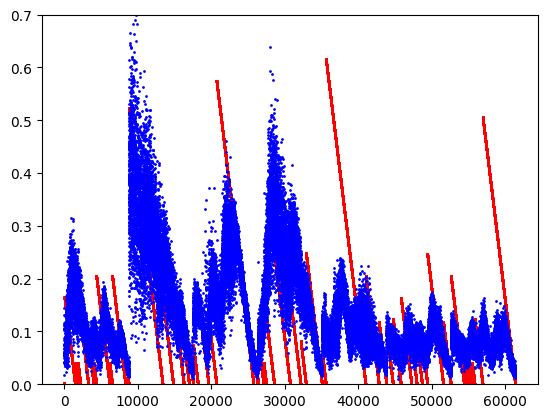

MAE:0.0961605891106393
MSE:0.0192385520618586


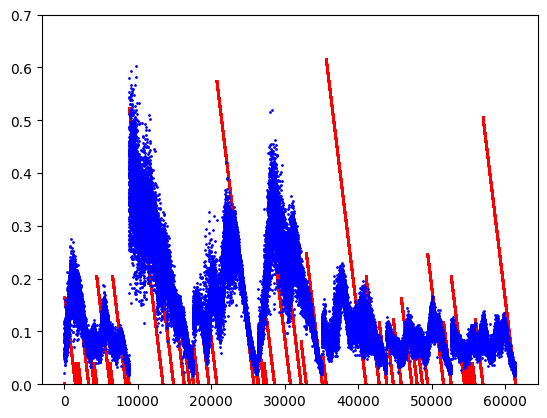

MAE:0.09479201271362843
MSE:0.018541534390780698


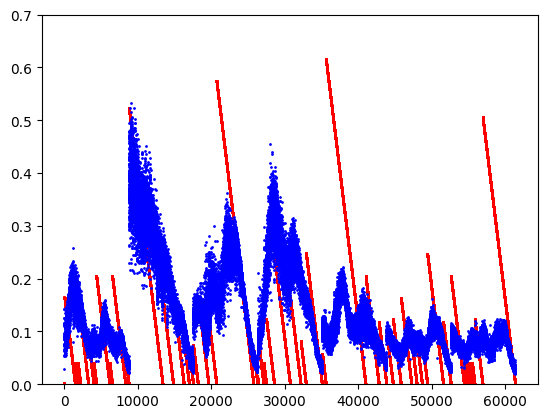

MAE:0.09416085730393652
MSE:0.018076434654899422


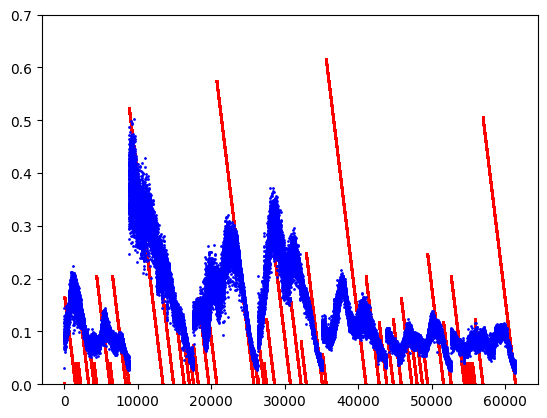

MAE:0.09403065481779876
MSE:0.01777730352404363


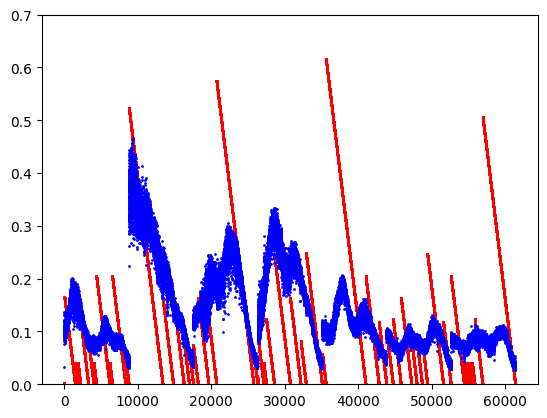

In [124]:
from sklearn import neighbors
neighbours = [2,4,8,16,32,64,128,256]
for i in neighbours:
    model = neighbors.KNeighborsRegressor(n_neighbors = i)
    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) 
    print_plot(y_test,pred)

MAE:0.09873954513707124
MSE:0.01840030226552709


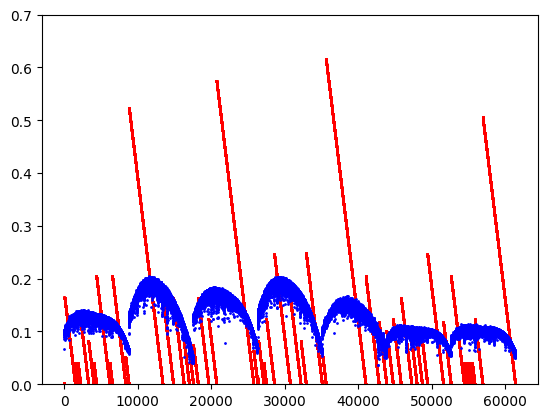

In [117]:
# Running this code takes time 
# Training of the SVC model
svr=SVR(C=0.1,gamma=1,kernel='rbf') 
svr.fit(X_train, y_train)
predict = svr.predict(X_test)
print_plot(y_test,predict)

In [ ]:
# Choose regression method and set hyperparameter
svr=SVR()  
# defining parameter range
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['linear','rbf']} 

clf = GridSearchCV(svr, param_grid, cv=5, verbose=4)
clf.fit(X_train, y_train)
print(clf.best_params_)

In [119]:
y_avg = np.average(y_train)
print(y_avg)

0.12808551178096186


In [120]:
predict = np.ones(len(y_test))*y_avg
print(predict.shape)

(61328,)


MAE:0.10473851286162118
MSE:0.019936266373857862


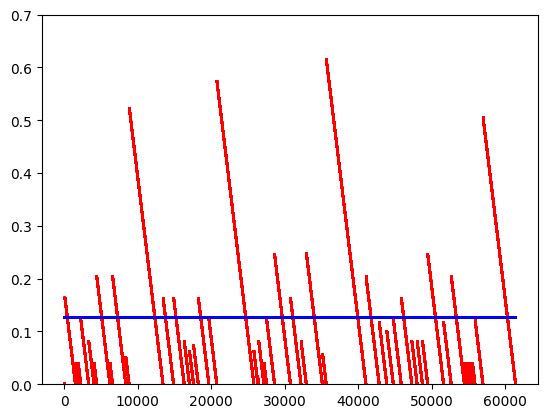

In [121]:
print_plot(y_test,predict)

MAE:1.5
MSE:2.5


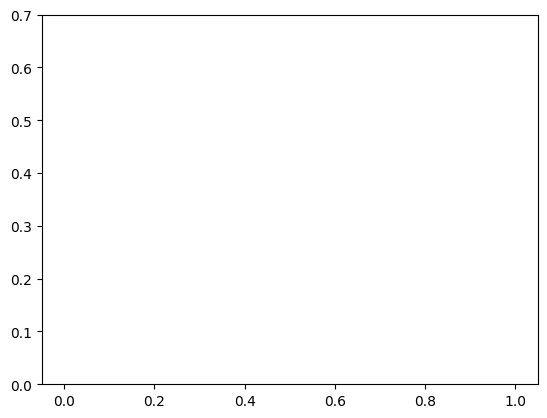

In [122]:
y=[1,2]
z=[2,4]
print_plot(np.asarray(y),np.asarray(z))